<a href="https://colab.research.google.com/github/ayushijainn111/SkimLit/blob/main/09_SkimLit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

**Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-680cd21a-ca6e-ff27-da4f-6459b95df3da)


## Get data
Since we'll be replicating the paper above(PubMeed 200k RCT), let's download the data they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 14.87 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all the file names in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocessed data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualise, Visualise, Visualise

So with that in mind, let's write a function to read in all of the lines of a target text file

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as list.

  Args:
  filename: a string containing the target filepath.

  Returns: A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()


In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") #read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...
\
```
[{'line_number':0,
    'target': 'BACKGROUND',
    'text': "Emotional eating is associated with overeating and the development of obesity .\n",
    'total_lines': 11}]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 325 ms, sys: 83.7 ms, total: 408 ms
Wall time: 410 ms


(180040, 30212, 30135)

In [11]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

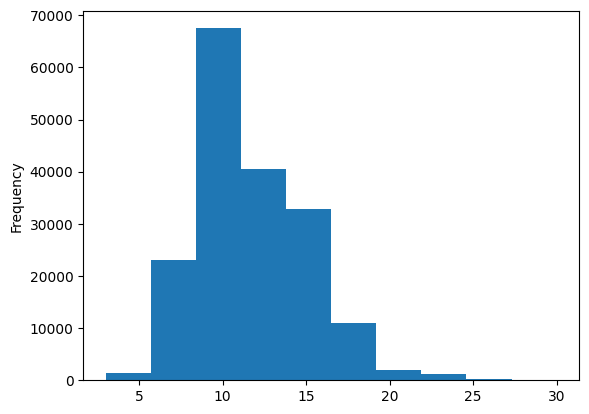

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()
print(len(train_sentences), len(val_sentences), len(test_sentences))

180040 30212 30135


In [16]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels(ML model require numeric labels)

In [17]:
# One hoe encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y = val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

## Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics(accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script.
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-08-03 10:26:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-08-03 10:26:48 (85.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
# How long is each sentence on average??
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
# max_sent_len = np.max(sent_lens)
# min_sent_len = np.min(sent_lens)
avg_sent_len

np.float64(26.338269273494777)

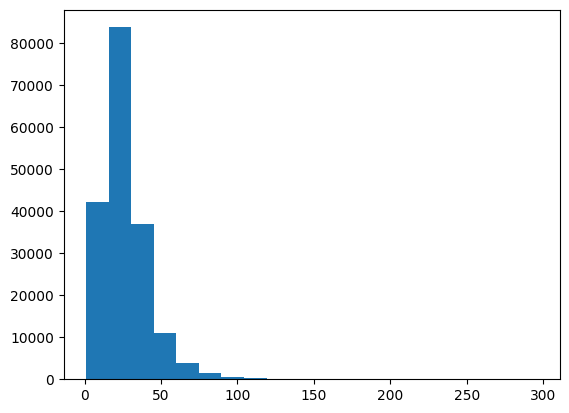

In [29]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)
plt.show()

In [30]:
# How long of a sentence length covers 95% of example?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [31]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [32]:
# How many words are in our vocabulary? (taken from table 2 in https://arxiv.org/abs/1710.06071)
max_tokens = 68000

In [33]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, #number of words in vocabulary
                                    output_sequence_length = output_seq_len) #desired output length of vectorized sequences


In [34]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [35]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVecotrized text:\n{text_vectorizer([target_sentence])}")


Text:
at @ months postoperatively , secure-c demonstrated clinically significant improvement in pain and function in terms of neck disability index , visual analogue scale , and @-item short form health survey .

Length of text: 205

Vecotrized text:
[[   15    41   721 16586   371   463    37   194     5    65     3   149
      5   614     4   932   612   203   290  1079   158     3  1500   654
    920    97   885     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [36]:
# How many words in our training vocalbylary
rct_20k_text_vocab= text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most commonn words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most commonn words in the vocab: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Least common words in the vocab: [np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]


In [37]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [38]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), #length of vocabulary
                               output_dim = 128, #Note: different embedding size result in drastically different number of parameters
                               mask_zero = True, #use making to handle variable sequence lengths(save space)
                               name = "token_embedding")

In [39]:
# Show example embedding
print(f"Sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding): \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Embedded sentence: \n {embedded_sentence} \n")
print(f"Embedded sentence shape: \n {embedded_sentence.shape}")

Sentence before vectorization: 
 at @ months postoperatively , secure-c demonstrated clinically significant improvement in pain and function in terms of neck disability index , visual analogue scale , and @-item short form health survey .

Sentence after vectorization (before embedding): 
 [[   15    41   721 16586   371   463    37   194     5    65     3   149
      5   614     4   932   612   203   290  1079   158     3  1500   654
    920    97   885     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded sentence: 
 [[[-0.04860098  0.03189564  0.02968038 ... -0.03375973  0.01104373
   -0.01470479]
  [ 0.00786604  0.0151183   0.02479477 ... -0.01368499 -0.04531651
   -0.03493869]
  [ 0.04836121  0.00220335  0.04996527 ...  0.04216364  0.04588166
   -0.0369064 ]
  ...
  [-0.02057498  0.02328707 -0.02318782 ... -0.03485151  0.03239209
    0.03652665]
  [-0.0

## Creating datasets(making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:



In [40]:
import tensorflow as tf

# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [41]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [42]:
num_classes

5

In [43]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) #vectorize text inputs
token_embeddings = token_embed(text_vectors) #create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPool1D()(x) #condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")

# Compile
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [44]:
model_1.summary()

Model: "model_1_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
len(train_dataset)

5627

In [46]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)), #only validate on 10% of batches
                              epochs = 3)

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5557 - loss: 1.0984 - val_accuracy: 0.7786 - val_loss: 0.5925
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7861 - loss: 0.5936 - val_accuracy: 0.7992 - val_loss: 0.5439
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7992 - loss: 0.5452 - val_accuracy: 0.8112 - val_loss: 0.5264


In [47]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8054 - loss: 0.5231


[0.5259581208229065, 0.8056401610374451]

In [48]:
# Making predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


(array([[6.2116545e-01, 6.2227510e-02, 2.2323537e-03, 3.1212446e-01,
         2.2502979e-03],
        [2.5890550e-01, 6.0209167e-01, 6.2192156e-04, 1.3614951e-01,
         2.2313900e-03],
        [1.9329768e-01, 9.9181095e-03, 1.3227878e-03, 7.9493326e-01,
         5.2811566e-04],
        ...,
        [2.0070108e-04, 2.3142970e-03, 9.8882662e-03, 2.7395069e-04,
         9.8732275e-01],
        [2.6707424e-02, 6.7718381e-01, 1.9888155e-02, 2.5923068e-02,
         2.5029755e-01],
        [2.0295676e-02, 9.7323555e-01, 8.9149893e-04, 2.9533945e-03,
         2.6240370e-03]], dtype=float32),
 (30212, 5))

In [49]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [50]:
# Calculate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 80.56401429895405,
 'precision': 0.8042794459612864,
 'recall': 0.8056401429895406,
 'f1': 0.8038952065889821}

In [51]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token modelling

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [52]:
import tf_keras as keras
import tensorflow_hub as hub
from tf_keras import layers

In [53]:
# Enable XLA
tf.config.optimizer.set_jit(True)  # Enable XLA (just-in-time compilation)

In [54]:
# Download pretrained TensorFlow Hub USE

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [55]:
# test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding: {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence: 
 engagement in agonist therapy was associated with a greater likelihood of illicit-opioid abstinence .
Sentence after embedding: [ 0.05044008  0.03203999 -0.03284987 -0.07698916 -0.05096514  0.03033113
  0.02348874 -0.03881712  0.04576837  0.0227318   0.08130091 -0.00925989
  0.03670309 -0.0003241   0.06667028 -0.04640439 -0.07941599  0.04444691
  0.0151183   0.04342034 -0.03633633  0.02915691 -0.00032248 -0.04652566
  0.01134439  0.02769328  0.00925447 -0.06289116 -0.04610673  0.01553859]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [56]:
class UniversalSentenceEncoderLayer(layers.Layer):
    def __init__(self, hub_layer):
        super().__init__()
        self.encoder = hub_layer

    def call(self, inputs):
        return self.encoder(inputs)

use_layer = UniversalSentenceEncoderLayer(tf_hub_embedding_layer)

inputs = layers.Input(shape=[], dtype=tf.string)
# Use Lambda to call the embedding function, and specify the output shape
# The output shape is (512,) because the USE model returns a 512-dimensional vector.
pretrained_embedding = use_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding as experimentation
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = keras.Model(inputs=inputs,  # <---- HERE
                        outputs=outputs,
                        name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),   # <------ HERE
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
 _layer (UniversalSentenceE                                      
 ncoderLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_____________________________________________________

In [57]:
# # Define feature extraction model using TF Hub layer
# inputs = layers.Input(shape = [], dtype=tf.string)
# # Wrap the TF Hub layer in a Keras layer call
# pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create embedding
# x = layers.Dense(128, activation="relu")(pretrained_embedding)
# # Note: you could add more layers if you wanted to
# outputs = layers.Dense(num_classes, activation="softmax")(x) #create a outputs layer
# model_2 = tf.keras.Model(inputs = inputs,
#                          outputs = outputs,
#                          name="model_2_USE_feature_extractor")

# # Compile
# model_2.compile(loss = "categorical_crossentropy",
#                 optimizer = tf.keras.optimizers.Adam(),
#                 metrics = ["accuracy"])

In [58]:
history_model_2 = model_2.fit(
                              train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # use 10% of the data
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 47s 45ms/step - loss: 0.9195 - accuracy: 0.6475 - val_loss: 0.7981 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 150s 267ms/step - loss: 0.7700 - accuracy: 0.7000 - val_loss: 0.7547 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7531 - accuracy: 0.7128 - val_loss: 0.7384 - val_accuracy: 0.7161


In [59]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7419 - accuracy: 0.7145


[0.74187833070755, 0.7144511938095093]

In [60]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 26s 13ms/step


array([[4.3760720e-01, 3.3760133e-01, 2.3694548e-03, 2.1481289e-01,
        7.6090144e-03],
       [3.3452433e-01, 5.0682670e-01, 3.7379945e-03, 1.5243480e-01,
        2.4762426e-03],
       [2.4827972e-01, 1.3937762e-01, 1.6745286e-02, 5.5755502e-01,
        3.8042307e-02],
       ...,
       [1.5647371e-03, 3.7120318e-03, 4.0539846e-02, 7.8199292e-04,
        9.5340139e-01],
       [3.6775228e-03, 4.9291905e-02, 1.8615748e-01, 1.2669486e-03,
        7.5960612e-01],
       [1.5319993e-01, 3.0386725e-01, 4.9335912e-01, 7.0906812e-03,
        4.2482987e-02]], dtype=float32)

In [61]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [62]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_2_preds)
model_2_results

{'accuracy': 71.44512114391632,
 'precision': 0.7145462290872399,
 'recall': 0.7144512114391632,
 'f1': 0.7116289400572035}

In [63]:
model_1_results

{'accuracy': 80.56401429895405,
 'precision': 0.8042794459612864,
 'recall': 0.8056401429895406,
 'f1': 0.8038952065889821}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of spoken and character-level embeddings

Previously we've token - level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character level tokenizer

In [64]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [65]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'e n g a g e m e n t   i n   a g o n i s t   t h e r a p y   w a s   a s s o c i a t e d   w i t h   a   g r e a t e r   l i k e l i h o o d   o f   i l l i c i t - o p i o i d   a b s t i n e n c e   .'

In [66]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [67]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(149.3662574983337)

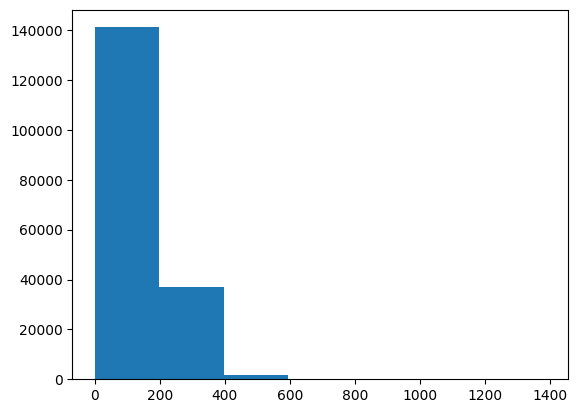

In [68]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [69]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [70]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [71]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [72]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
5 least common characters: [np.str_('k'), np.str_('x'), np.str_('z'), np.str_('q'), np.str_('j')]


In [73]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
a d d i t i o n a l   r e s e a r c h   i s   n e e d e d   t o   i d e n t i f y   f a c t o r s   t h a t   o p t i m i z e   r e s p o n s i v e n e s s   t o   e x e r c i s e   t o   m a x i m i z e   i t s   f u n c t i o n a l   b e n e f i t s   i n   o l d e r   a d u l t s   .

Length of chars: 124

Vectorized chars:
[[ 5 10 10  4  3  4  7  6  5 12  8  2  9  2  5  8 11 13  4  9  6  2  2 10
   2 10  3  7  4 10  2  6  3  4 17 19 17  5 11  3  7  8  9  3 13  5  3  7
  14  3  4 15  4 25  2  8  2  9 14  7  6  9  4 21  2  6  2  9  9  3  7  2
  24  2  8 11  4  9  2  3  7 15  5 24  4 15  4 25  2  4  3  9 17 16  6 11
   3  4  7  6  5 12 22  2  6  2 17  4  3  9  4  6  7 12 10  2  8  5 10 16
  12  3  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

## Creating a character-level embedding

In [74]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a d d i t i o n a l   r e s e a r c h   i s   n e e d e d   t o   i d e n t i f y   f a c t o r s   t h a t   o p t i m i z e   r e s p o n s i v e n e s s   t o   e x e r c i s e   t o   m a x i m i z e   i t s   f u n c t i o n a l   b e n e f i t s   i n   o l d e r   a d u l t s   .

Embedded chars (after vectorization and embedding):
[[[-0.01493458 -0.03191395 -0.03869279 ... -0.00899842 -0.0409678
    0.03126903]
  [ 0.01810523 -0.0386513  -0.02520188 ...  0.01079707 -0.04883654
   -0.02962661]
  [ 0.01810523 -0.0386513  -0.02520188 ...  0.01079707 -0.04883654
   -0.02962661]
  ...
  [ 0.03137244 -0.04530273  0.01877468 ...  0.04195258  0.04446718
   -0.03173612]
  [ 0.03137244 -0.04530273  0.01877468 ...  0.04195258  0.04446718
   -0.03173612]
  [ 0.03137244 -0.04530273  0.01877468 ...  0.04195258  0.04446718
   -0.03173612]]]

Character embedding shape: (1, 290, 25)


In [75]:
len(random_train_chars)

287

### Building a Conv1D model to fit on character embeddinds

In [76]:
# # Make Conv1D on chars only
# inputs = layers.Input(shape=(1,), dtype="string")
# char_vectors = char_vectorizer(inputs)
# char_embeddings = char_embed(char_vectors)
# x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
# x = layers.GlobalMaxPool1D()(x)
# outputs = layers.Dense(num_classes, activation="softmax")(x)
# model_3 = tf.keras.Model(inputs=inputs,
#                          outputs=outputs,
#                          name="model_3_conv1D_char_embedding")

# # Compile model
# model_3.compile(loss="categorical_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

In [77]:
class CharVectorizerLayer(tf.keras.layers.Layer):
    def __init__(self, vectorizer, **kwargs):
        super().__init__(**kwargs)
        self.vectorizer = vectorizer

    def call(self, inputs):
        return self.vectorizer(inputs)

In [78]:
# output_seq_char_len = 290  # or match your vectorizer's output sequence length

# char_embed = layers.Embedding(
#     input_dim=NUM_CHAR_TOKENS,
#     output_dim=25,
#     mask_zero=False,
#     name="char_embed"
# )

# inputs = layers.Input(shape=(), dtype="string", name="char_input")

# # ✅ Use the safe wrapper layer instead of Lambda
# char_vectors = CharVectorizerLayer(char_vectorizer)(inputs)

# char_embeddings = char_embed(char_vectors)
# x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
# x = layers.GlobalMaxPool1D()(x)
# outputs = layers.Dense(num_classes, activation="softmax")(x)

# model_3 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_3_conv1D_char_embedding")

# model_3.compile(
#     loss="categorical_crossentropy",
#     optimizer="adam",
#     metrics=["accuracy"]
# )

In [79]:
# # Summary
# model_3.summary()

In [80]:
# Create char level datasets
train_char_datasets = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_datasets = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_datasets = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_datasets

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [81]:
# # Fit the model on chars only
# model_3_history = model_3.fit(train_char_datasets,
#                               steps_per_epoch=int(0.1*len(train_char_datasets)),
#                               epochs=3,
#                               validation_data=val_char_datasets,
#                               validation_steps=int(0.1*len(val_char_datasets)))

In [82]:
# # Make predictions with character model only
# model_3_pred_probs = model_3.predict(val_char_datasets)
# model_3_pred_probs

In [83]:
# # Convert prediction probabilities to class labels
# model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
# model_3_preds

In [84]:
# # Calculate results for Conv1D model chars
# model_3_results = calculate_results(y_true = val_labels_encoded,
#                                     y_pred = model_3_preds)

In [85]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layers)

1. Create a token-level embedding model (similar `model_1`)
2. Create character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar Figure 1 and section 4.2 of the paper.
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [86]:
# # 1. Setup token inputs/model
# token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
# token_embeddings = tf_hub_embedding_layer(token_inputs)
# token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
# token_model = tf.keras.Model(inputs=token_inputs,
#                              outputs=token_outputs)

# # 2. Setup char inputs/model
# char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
# char_vectors = char_vectorizer(char_inputs)
# char_embeddings = char_embed(char_vectors)
# char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #bi-LSTM shown in Figure 1 of https://arxiv.org/abs/1612.05251
# char_model = tf.keras.Model(inputs=char_inputs,
#                             outputs=char_bi_lstm)

# # 3. Concatenate token and char inputs(create hybrid token embedding)
# token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
#                                                                  char_model.output])

# # 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/abs/1612.05251
# combined_dropout = layers.Dropout(0.5)(token_char_concat)
# combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
# final_dropout = layers.Dropout(0.5)(combined_dense)
# output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# # 5. Construct model with char and token inputs
# model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
#                          outputs=output_layer,
#                          name = "model_4_token_and_char_embeddings")

In [87]:
# Imports (ensure these are at the top of your notebook)
import tensorflow as tf
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Custom character vectorizer wrapper to avoid TF API dispatch error
class CharVectorizerLayer(tf.keras.layers.Layer):
    def __init__(self, vectorizer):
        super().__init__()
        self.vectorizer = vectorizer

    def call(self, inputs):
        return self.vectorizer(inputs)

# Define character-level alphabet
import string
alphabet = list(string.ascii_lowercase + string.digits + string.punctuation + ' ')  # or your own list

# Create character-level TextVectorization layer
NUM_CHAR_TOKENS = len(alphabet) + 2  # +1 for space, +1 for OOV
output_seq_char_len = 290  # or whatever your desired char sequence length is

char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    standardize="lower_and_strip_punctuation",
    name="char_vectorizer"
)

# Adapt the char vectorizer to your character training data
# Ensure train_chars is defined properly (list/array of strings)
char_vectorizer.adapt(train_chars)

# Wrap it in a Keras-compatible layer
char_vectorizer_layer = CharVectorizerLayer(char_vectorizer)

# Get vocab size
char_vocab_size = len(char_vectorizer.get_vocabulary())

# Character Embedding layer
char_embed = tf.keras.layers.Embedding(
    input_dim=char_vocab_size,
    output_dim=10,
    mask_zero=False,
    name="char_embed",
    trainable = False
)

# 1. Token-level input
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_input")
token_vectors = text_vectorizer(token_inputs)
token_embed = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()), output_dim=128)(token_vectors)
token_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(token_embed)

# 2. Character-level input
char_inputs = layers.Input(shape=(), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer_layer(char_inputs)               # int sequences
char_embeddings = char_embed(char_vectors)                      # embedded sequences
char_bi_lstm = tf.keras.layers.Bidirectional(layers.LSTM(24))(char_embeddings)

# 3. Line number input
line_number_input = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
line_dense = layers.Dense(32, activation="relu")(line_number_input)

# 4. Total lines input
total_lines_input = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
total_lines_dense = layers.Dense(32, activation="relu")(total_lines_input)

# Combine all features
combined = layers.Concatenate()([token_lstm, char_bi_lstm, line_dense, total_lines_dense])
combined_dense = layers.Dense(128, activation="relu")(combined)
output = layers.Dense(5, activation="softmax", name="output")(combined_dense)

# Define model
model_4 = tf.keras.Model(
    inputs=[token_inputs, char_inputs, line_number_input, total_lines_input],
    outputs=output,
    name="model_4_char_token"
)


In [88]:
# Get a summary of our model
model_4.summary()

Model: "model_4_char_token"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 55)        │          0 │ token_input[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer_la… │ (None, None)      │          0 │ char_input[0][0]  │
│ (CharVectorizerLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 55, 128)   │  8,299,648 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, None, 10)  │        280 │ char_vectorizer_… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 48)        │      6,720 │ char_embed[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 240)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     30,848 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 5)         │        645 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,438,141 (32.19 MB)

 Trainable params: 8,437,861 (32.19 MB)

 Non-trainable params: 280 (1.09 KB)

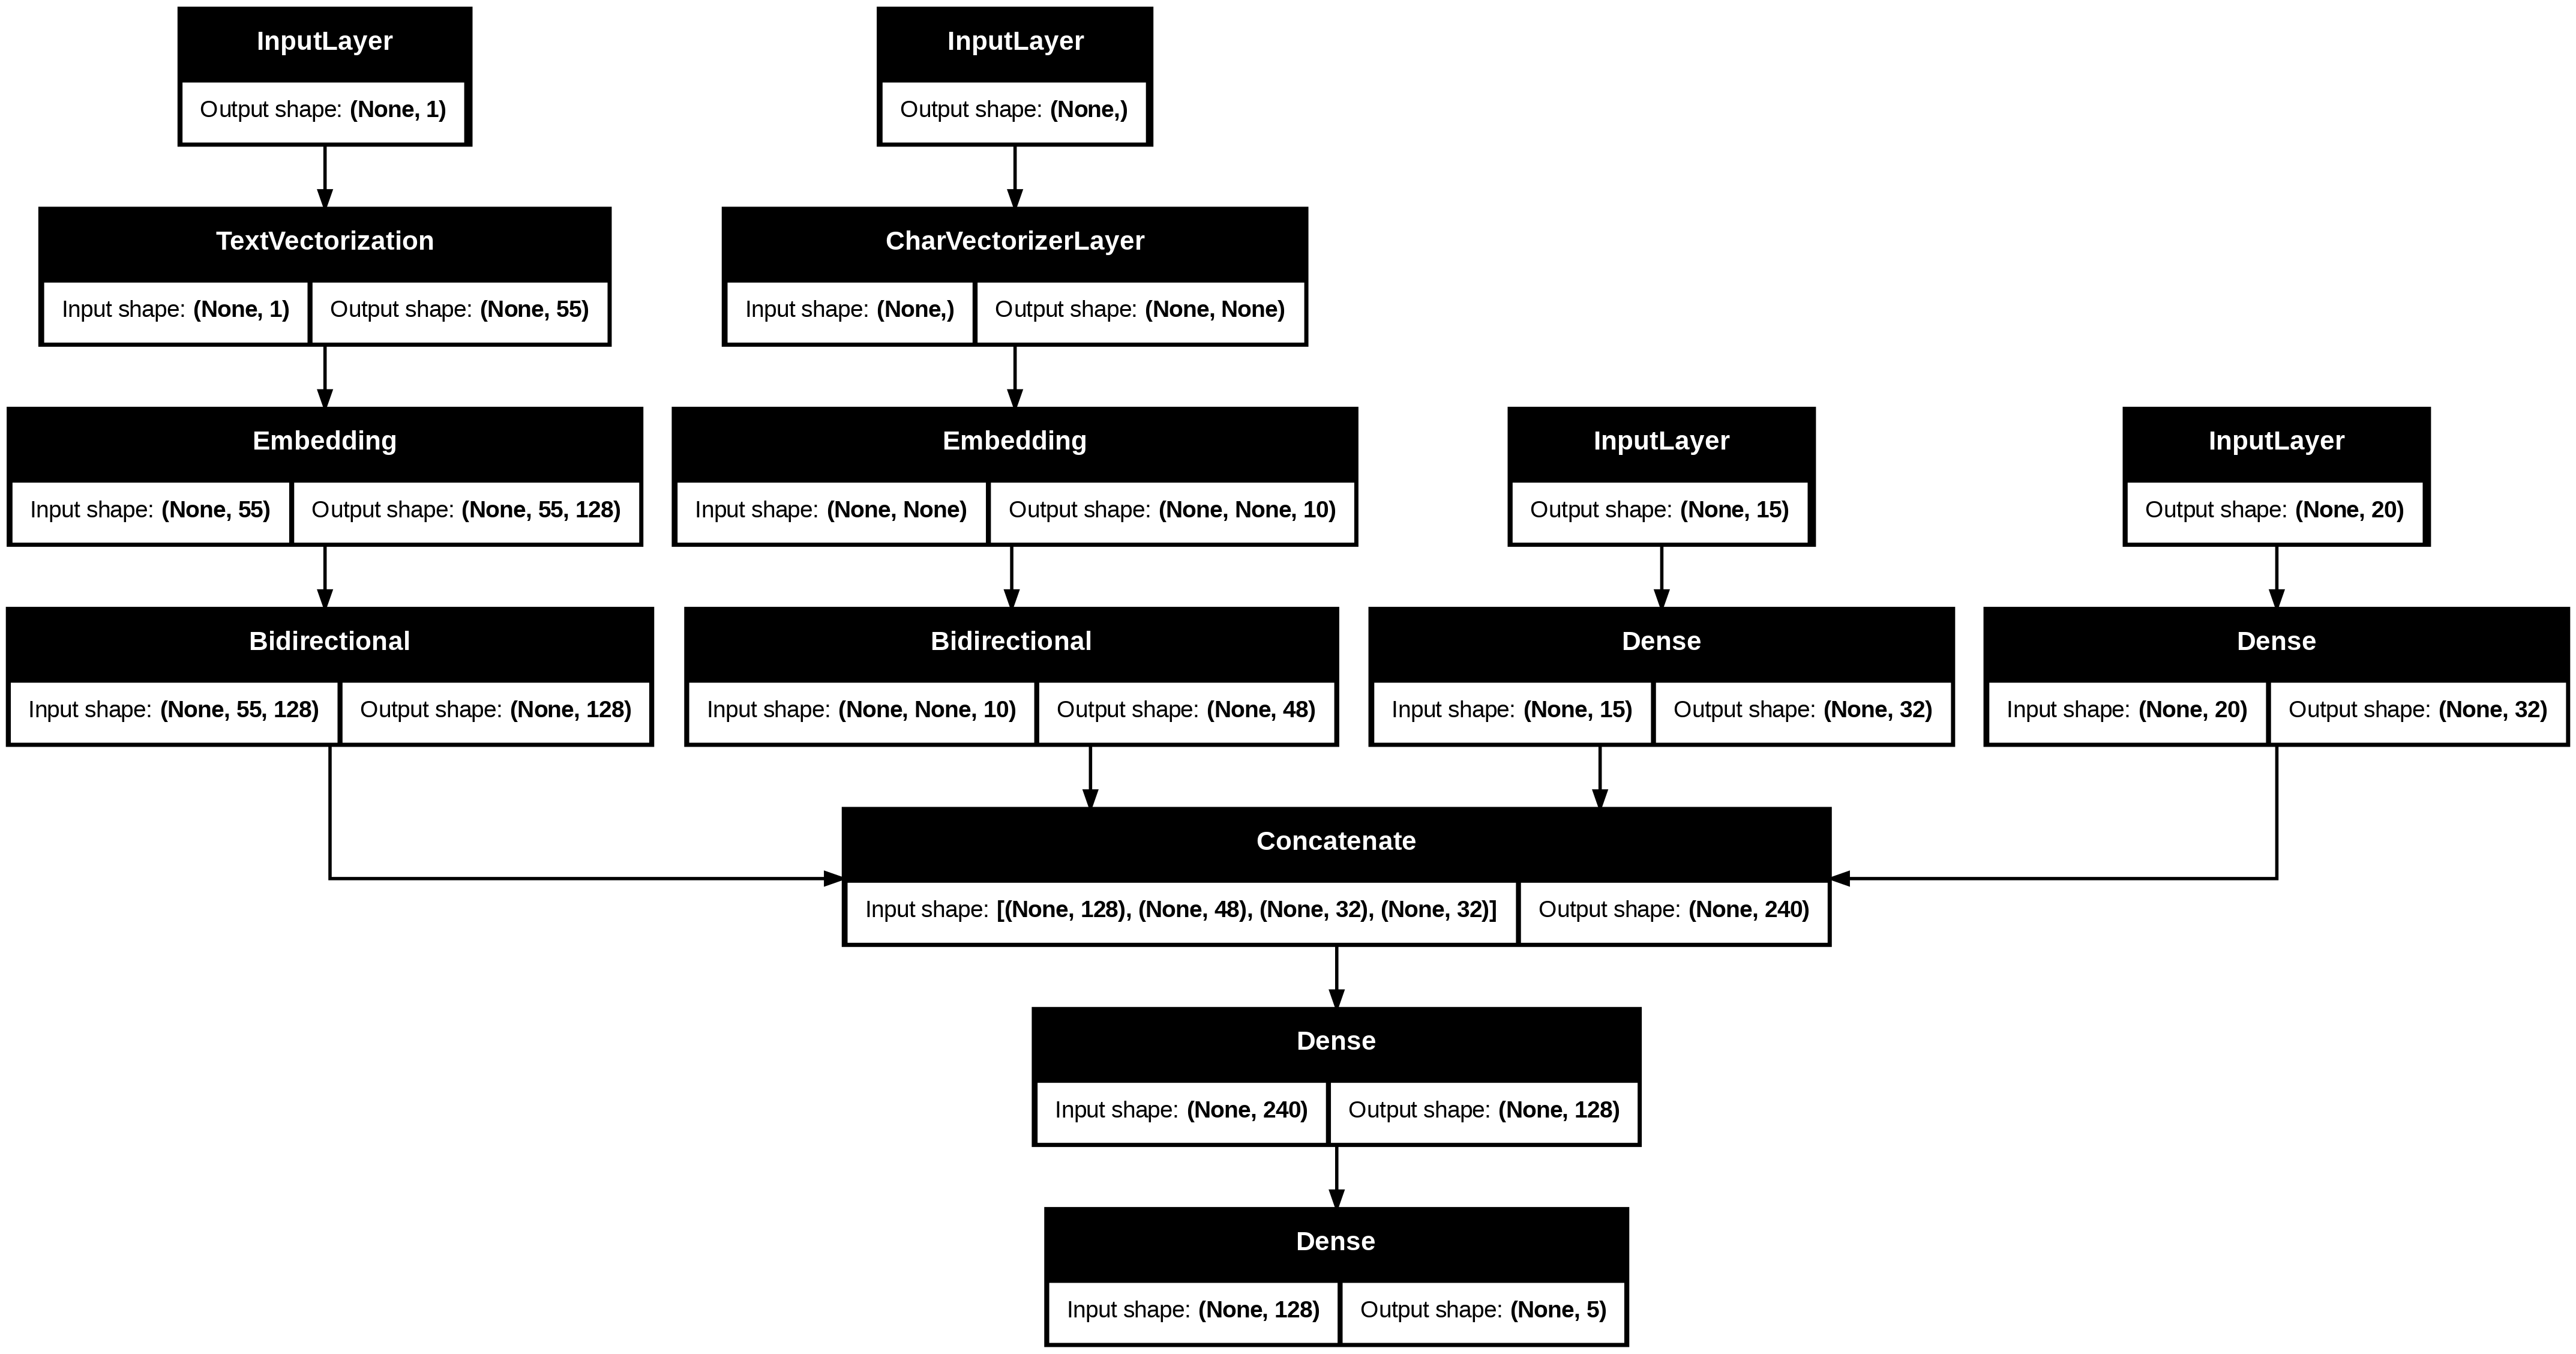

In [89]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [90]:
# Compile token char model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Combining token and character data into a tf.data.Dataset

In [91]:
# Combine chars and tokens into a datasets
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) #combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#

In [92]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) #combine data and labels

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [93]:
# Checkout our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [94]:
# Define depth
line_number_depth = train_df["line_number"].max() + 1
total_lines_depth = train_df["total_lines"].max() + 1

# One-hot encode
line_number_depth = 15
total_lines_depth = 20
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=line_number_depth)
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=total_lines_depth)

val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=line_number_depth)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=total_lines_depth)

In [95]:
# Train inputs
train_inputs = {
    "token_input": train_sentences,
    "char_input": train_chars,
    "line_number_input": train_line_numbers_one_hot,
    "total_lines_input": train_total_lines_one_hot
}

# Validation inputs
val_inputs = {
    "token_input": val_sentences,
    "char_input": val_chars,
    "line_number_input": val_line_numbers_one_hot,
    "total_lines_input": val_total_lines_one_hot
}

In [96]:
# Train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels_one_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels_one_hot))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Fit the model on token and character-level sequences

In [97]:
history_model_4 = model_4.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.6530 - loss: 0.8688 - val_accuracy: 0.8404 - val_loss: 0.4130
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.8467 - loss: 0.4102 - val_accuracy: 0.8514 - val_loss: 0.3866
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8570 - loss: 0.3660 - val_accuracy: 0.8564 - val_loss: 0.3504


In [98]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8610 - loss: 0.3453


[0.34814393520355225, 0.8628359436988831]

In [99]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step


array([[2.3623928e-01, 7.0947432e-04, 2.0137287e-03, 7.6080477e-01,
        2.3285796e-04],
       [4.3882284e-01, 1.0641251e-03, 2.8107765e-03, 5.5690753e-01,
        3.9472393e-04],
       [1.2675586e-01, 1.4151827e-03, 8.6431624e-03, 8.6207342e-01,
        1.1123206e-03],
       ...,
       [4.0823681e-05, 6.9060605e-03, 5.2341549e-03, 5.7907196e-06,
        9.8781312e-01],
       [3.4499582e-04, 9.2647260e-01, 4.2216774e-04, 5.4214255e-05,
        7.2706036e-02],
       [1.0021655e-02, 9.7324830e-01, 1.8145263e-03, 4.9506716e-04,
        1.4420431e-02]], dtype=float32)

In [100]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 3, ..., 4, 1, 1])>

In [101]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 86.28359592215014,
 'precision': 0.8642339839591322,
 'recall': 0.8628359592215014,
 'f1': 0.8628663521439455}

In [102]:
model_1_results

{'accuracy': 80.56401429895405,
 'precision': 0.8042794459612864,
 'recall': 0.8056401429895406,
 'f1': 0.8038952065889821}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [103]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note**: Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [104]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


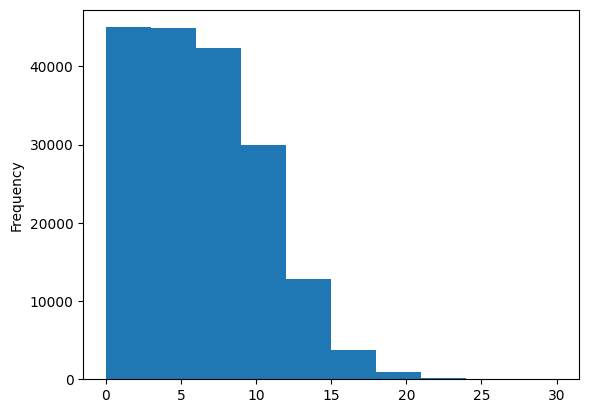

In [105]:
# Check the distribution of "line number" column
train_df["line_number"].plot.hist();

In [106]:
# Use TensorFlow to create one-hot-encoded tensors of our "line number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers features, let's do the same for our total lines features...

In [107]:
# How many different number of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

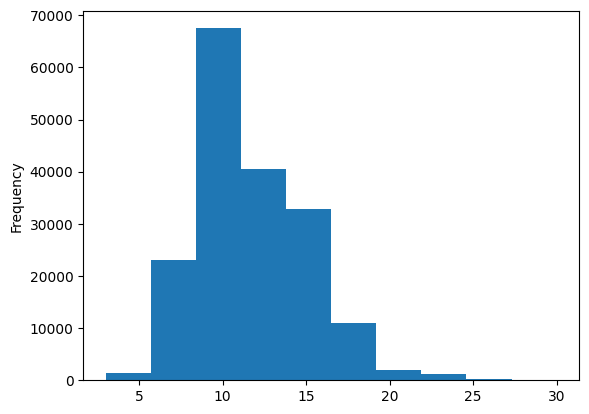

In [108]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [109]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

np.float64(20.0)

In [110]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines"
train_total_numbers_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_numbers_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_numbers_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_numbers_one_hot.shape, train_total_numbers_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" Feature
4. Create a model for the "total_lines" Feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 , 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilites.
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [151]:
!sudo apt-get update -y
!sudo apt-get install python3.10 python3.10-venv python3.10-dev -y
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --config python3
!python3 -m venv tfenv
!source tfenv/bin/activate && pip install --upgrade pip && pip install tensorflow==2.10.0 tensorflow-estimator==2.10.0

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,853 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,270 kB]
Get:13 http://archive.ubuntu.com/ubunt

In [153]:
!python3 --version

Python 3.10.12


In [154]:
class USEWrapperLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.use = None
        self._loaded = False

    def call(self, inputs):
        if not self._loaded:
            self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
            self._loaded = True
        return self.use(inputs)

In [155]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = USEWrapperLayer()(token_inputs)  # ✅ No tf.function binding error
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs
char_inputs  = layers.Input(shape = (1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output,
                                             char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([line_number_model.output,
                                                                                   total_lines_model.output,
                                                                                   z])
# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Combine inputs and outputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name = "model_5_tribrid_embedding_model")

In [156]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ use_wrapper_layer_2 │ (None, 512)       │          0 │ token_input[0][0] │
│ (USEWrapperLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 10)   │        280 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     65,664 │ use_wrapper_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 48)        │      6,720 │ char_embed[3][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_hybrid_… │ (None, 176)       │          0 │ dense_12[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_inputs  │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_inputs  │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │     45,312 │ char_token_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_positio… │ (None, 320)       │          0 │ dense_13[0][0],   │
│ (Concatenate)       │                   │            │ dense_14[0][0],   │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ char_token_posit… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,765 (471.74 KB)

 Trainable params: 120,485 (470.64 KB)

 Non-trainable params: 280 (1.09 KB)

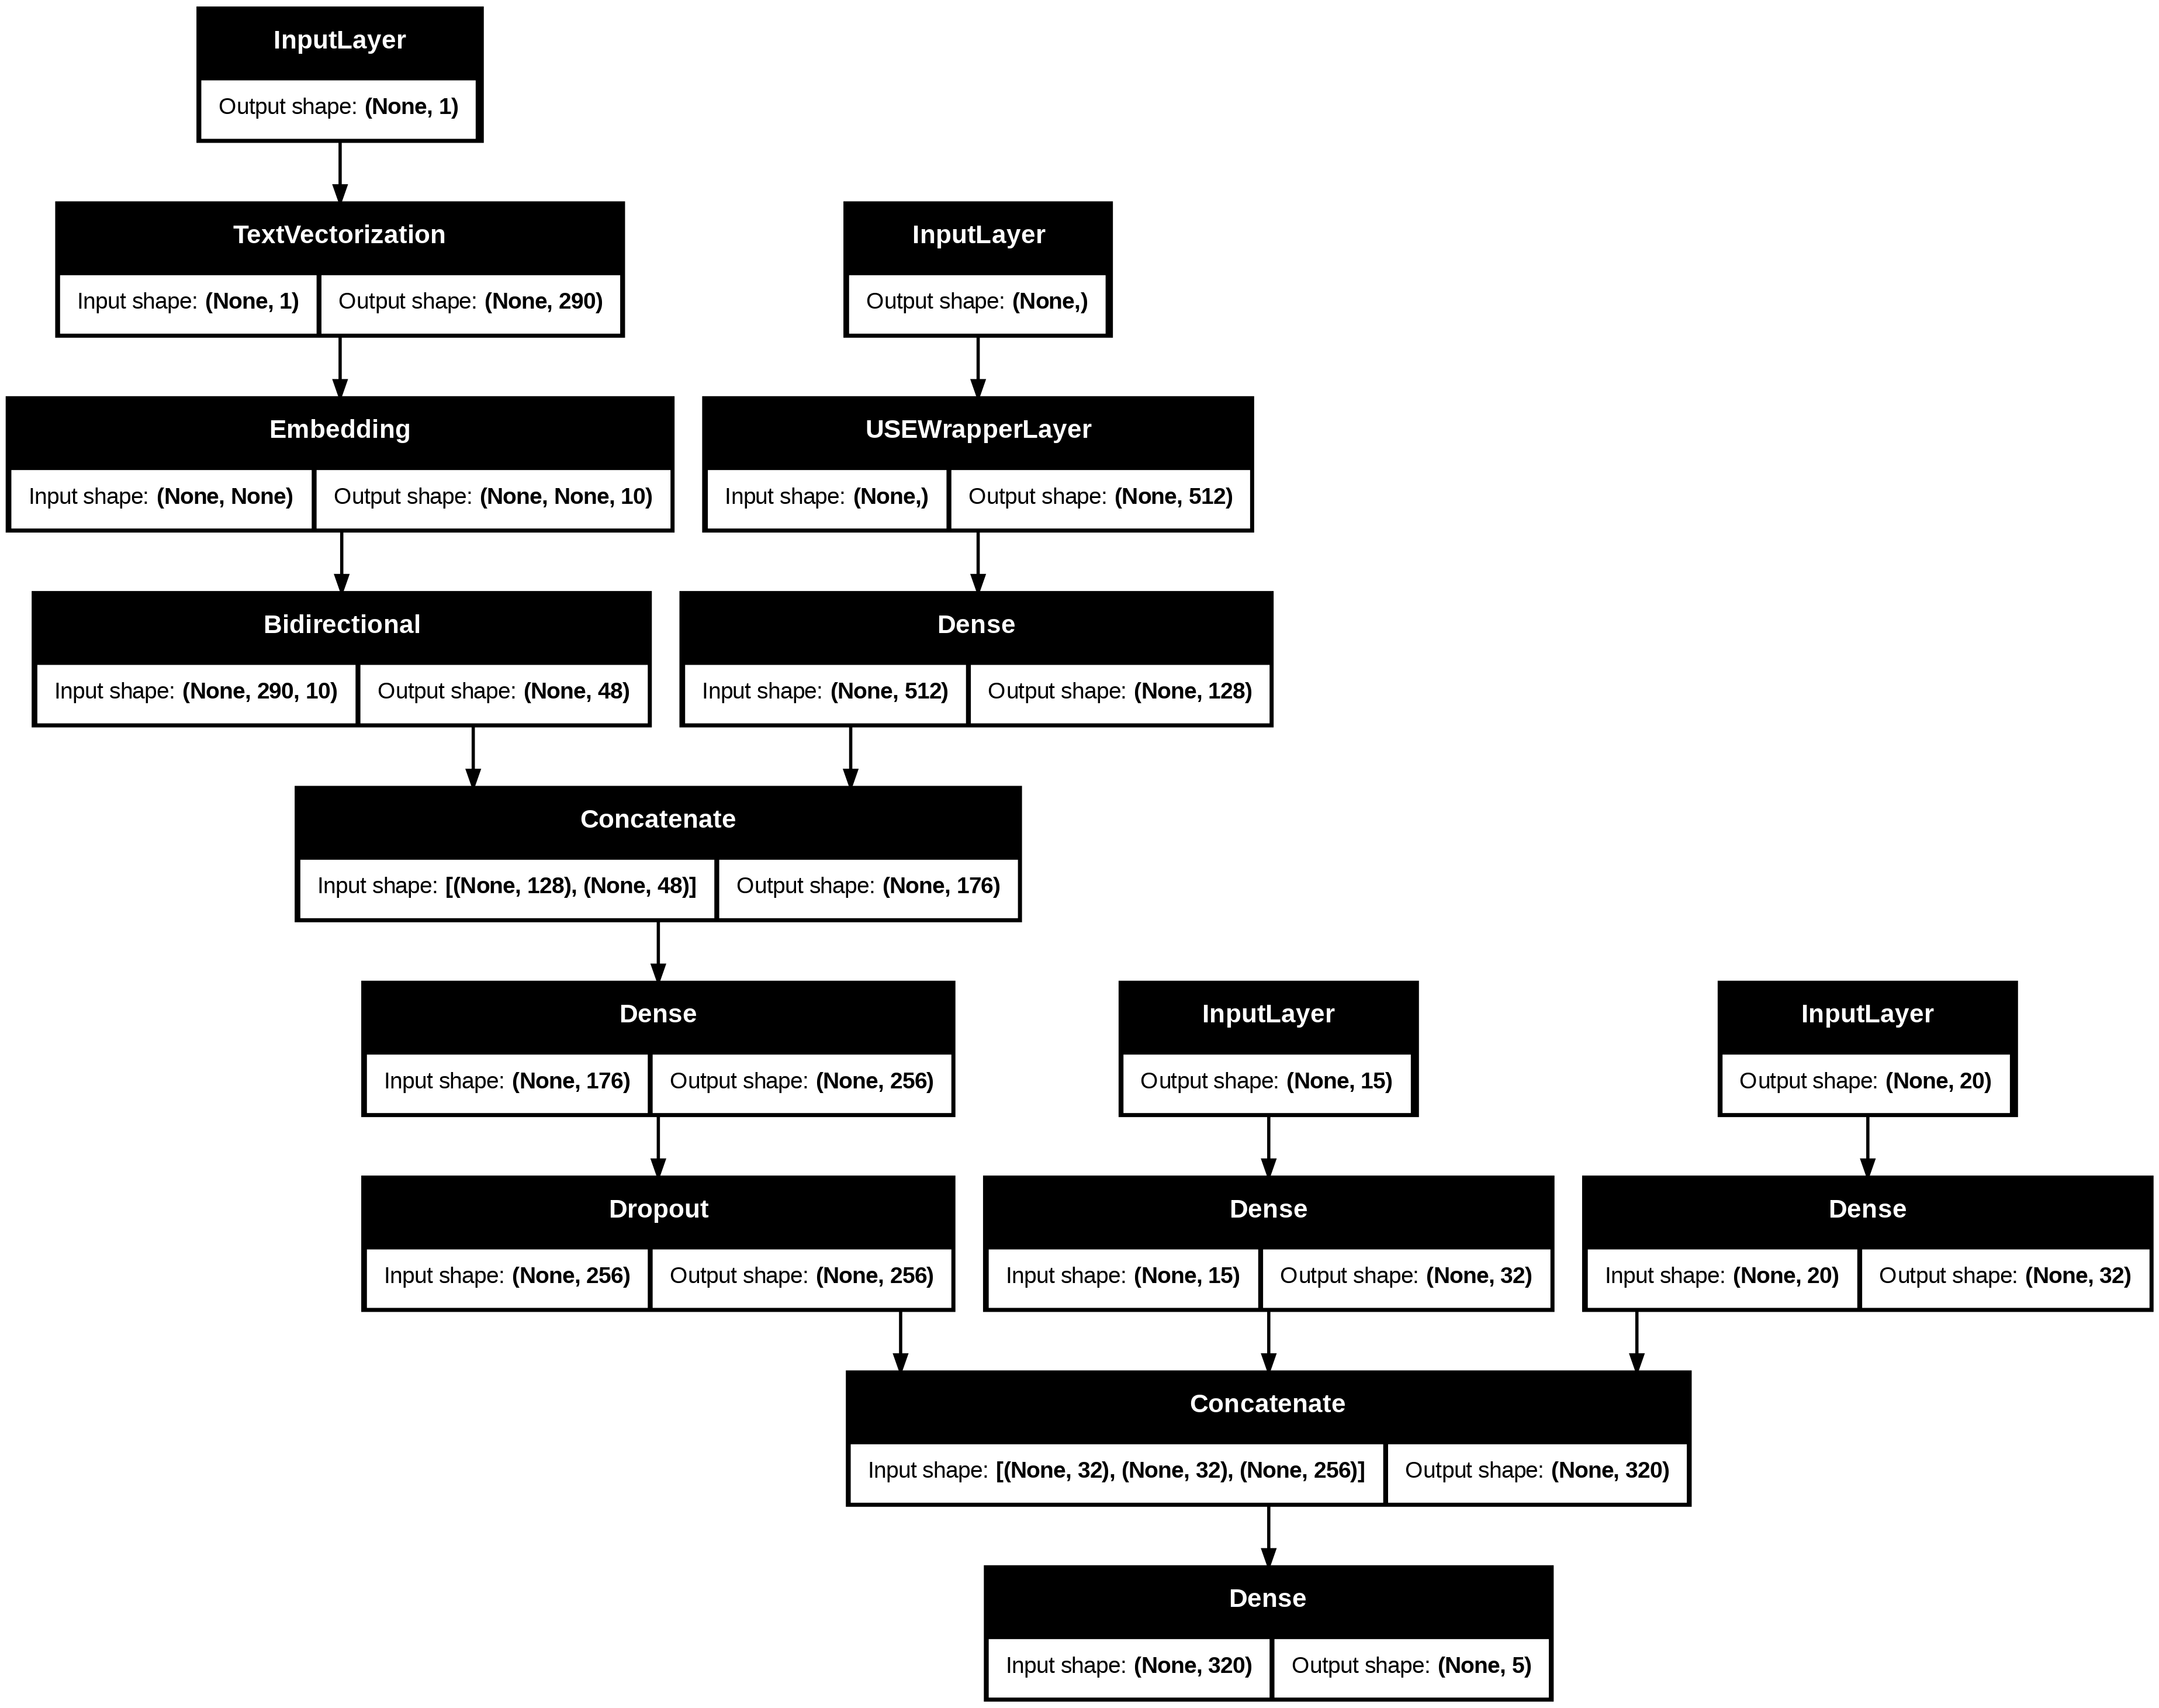

In [157]:
# Plot model_5 to explore it more
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothening?

for example if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes ....

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

In [158]:
# Compile token, char, and positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), #helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Create tribrid embedding datasets using tf.data

In [159]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [160]:
# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predicitons with our tribrid model

In [161]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps = int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 64s 65ms/step - accuracy: 0.6066 - loss: 1.2377 - val_accuracy: 0.8002 - val_loss: 0.9913
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 153s 272ms/step - accuracy: 0.8029 - loss: 0.9801 - val_accuracy: 0.8152 - val_loss: 0.9588
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.8167 - loss: 0.9590 - val_accuracy: 0.8278 - val_loss: 0.9464


In [162]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose = 1)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step


array([[0.5168348 , 0.11011012, 0.01154392, 0.3444148 , 0.01709642],
       [0.55146754, 0.11982108, 0.04379689, 0.27475852, 0.01015589],
       [0.25555837, 0.10887938, 0.13275608, 0.43666586, 0.06614026],
       ...,
       [0.03542707, 0.09988153, 0.047041  , 0.03613347, 0.78151697],
       [0.02571505, 0.25309658, 0.0777766 , 0.02357018, 0.6198415 ],
       [0.34802604, 0.47377446, 0.08123525, 0.05156453, 0.0453997 ]],
      dtype=float32)

In [163]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [164]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 82.7220971799285,
 'precision': 0.8262046515228949,
 'recall': 0.827220971799285,
 'f1': 0.8265082300430756}

## Compare model results

In [168]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline" : baseline_results,
                                  "model_1_custom_token_embedding" : model_1_results,
                                  "model_2_pretrained_token_embedding" : model_2_results,
                                  # "model_3_custom_char_embedding" : model_3_results,
                                  "model_4_hybrid_char_token_embedding" : model_4_results,
                                  "model_5_pos_char_token_embedding" : model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,80.564014,0.804279,0.805640,0.803895
model_2_pretrained_token_embedding,71.445121,0.714546,0.714451,0.711629
model_4_hybrid_char_token_embedding,86.283596,0.864234,0.862836,0.862866
model_5_pos_char_token_embedding,82.722097,0.826205,0.827221,0.826508


In [169]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

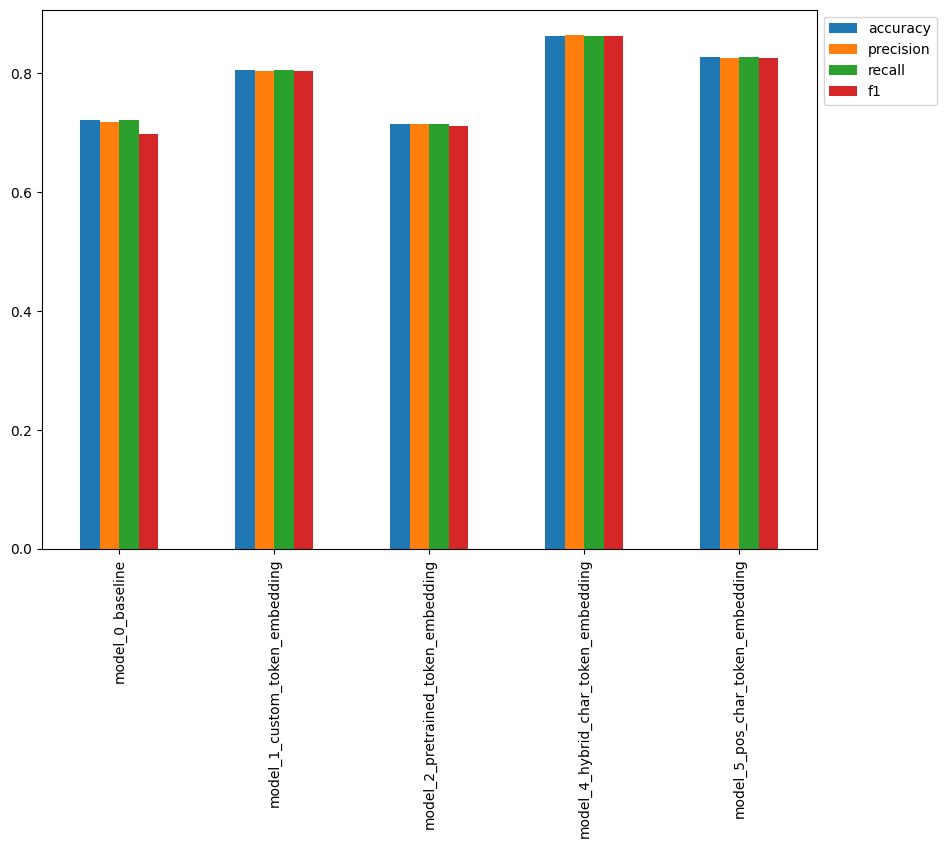

In [170]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

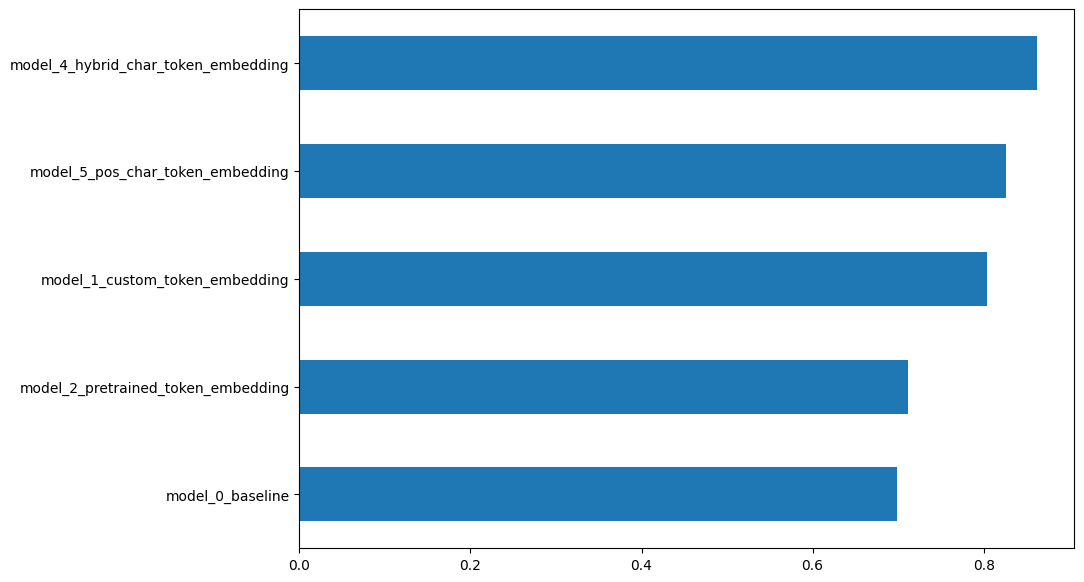

In [171]:
# Sort the models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="barh", figsize=(10, 7));

## Save and load model

In [172]:
# Save the best performing model to SaveModel format (default)
model_5.save("model5python3.10.keras")

In [146]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [149]:
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [150]:
!python --version

Python 3.11.13


In [127]:
class USEWrapperLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(USEWrapperLayer, self).__init__(**kwargs)
        self.use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    def call(self, inputs):
        return self.use_model(inputs)  # Output shape: (batch_size, 512)

In [173]:
# from keras.models import load_model

# loaded_model = load_model("skimlit_hybrid_model.keras", custom_objects={"USEWrapperLayer": USEWrapperLayer})

In [174]:
# # Make predictions
# loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset)
# loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
# loaded_preds[:10]

In [175]:
# # Calculate the results of loaded model
# loaded_model_results = calculate_results(y_true = val_labels_encoded,
#                                         y_pred = loaded_preds)
# loaded_model_results

In [176]:
# assert model_5_results == loaded_model_results

In [177]:
# # Check the loaded model summary
# loaded_model.summary()